In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import json
import os
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns 

# Importing librarys to use on interactive graphs
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/drive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/drive/test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
"""def load_df(csv_path='/content/drive/MyDrive/drive/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df"""

In [ ]:
def load_df(csv_path='/content/drive/MyDrive/drive/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,converters={column: json.loads for column in JSON_COLUMNS},dtype={'fullVisitorId': 'str'},nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
train = load_df()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded train.csv. Shape: (903653, 55)


### EDA

In [ ]:
df_train=train
df_train['totals.transactionRevenue'] = pd.to_numeric(df_train['totals.transactionRevenue'], downcast="float")

In [ ]:
#train['totals.transactionRevenue'] = pd.to_numeric(train['totals.transactionRevenue'], downcast="float")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



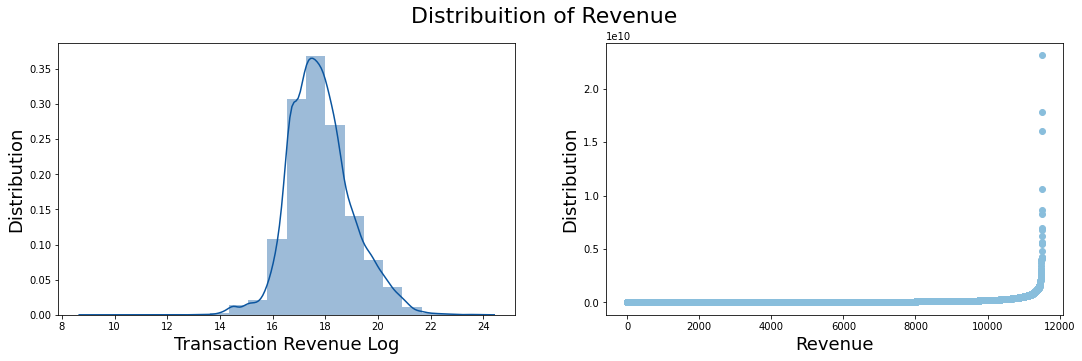

In [ ]:
fig = plt.figure(figsize=(18,5))
plt.suptitle('Distribuition of Revenue', fontsize=22)
ax1 = fig.add_subplot(121)
_ = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=20, color='#0b559f',ax=ax1)
_ = ax1.set_ylabel('Distribution', fontsize=18)
_ = ax1.set_xlabel('Transaction Revenue Log', fontsize=18)

ax2 = fig.add_subplot(122)
_ = plt.scatter(range(df_train.shape[0]), np.sort(df_train['totals.transactionRevenue'].values), color='#89bedc')
_ = ax2.set_ylabel('Distribution', fontsize=18)
_ = ax2.set_xlabel('Revenue', fontsize=18)

In [ ]:
def datadesc(df):
  print(f"Dataset Shape: {df.shape}")
  summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
  summary = summary.reset_index()
  #summary['name'] = summary['index']
  #summary = summary[['Name','dtypes']]
  summary['Missing'] = df.isnull().sum().values
  summary['nunique'] = df.nunique().values
  #summary['First Value'] = df.loc[0].values
  #summary['Second Value'] = df.loc[1].values
  return summary
datadesc(train).head(3)

Dataset Shape: (903653, 55)


,index,dtypes,Missing,nunique
0,channelGrouping,object,0,8
1,date,int64,0,366
2,fullVisitorId,object,0,714167


In [ ]:
#sns.relplot(data=train, x="totals.hits", y="totals.pageviews", hue ="totals.transactionRevenue")
#df_train['logrevenue'] = train.loc[train_df['totals.transactionRevenue']]
df_train['logrevenue'] = np.log1p(df_train["totals.transactionRevenue"].values)

In [ ]:
df_train.head()

Mean revenue per transaction


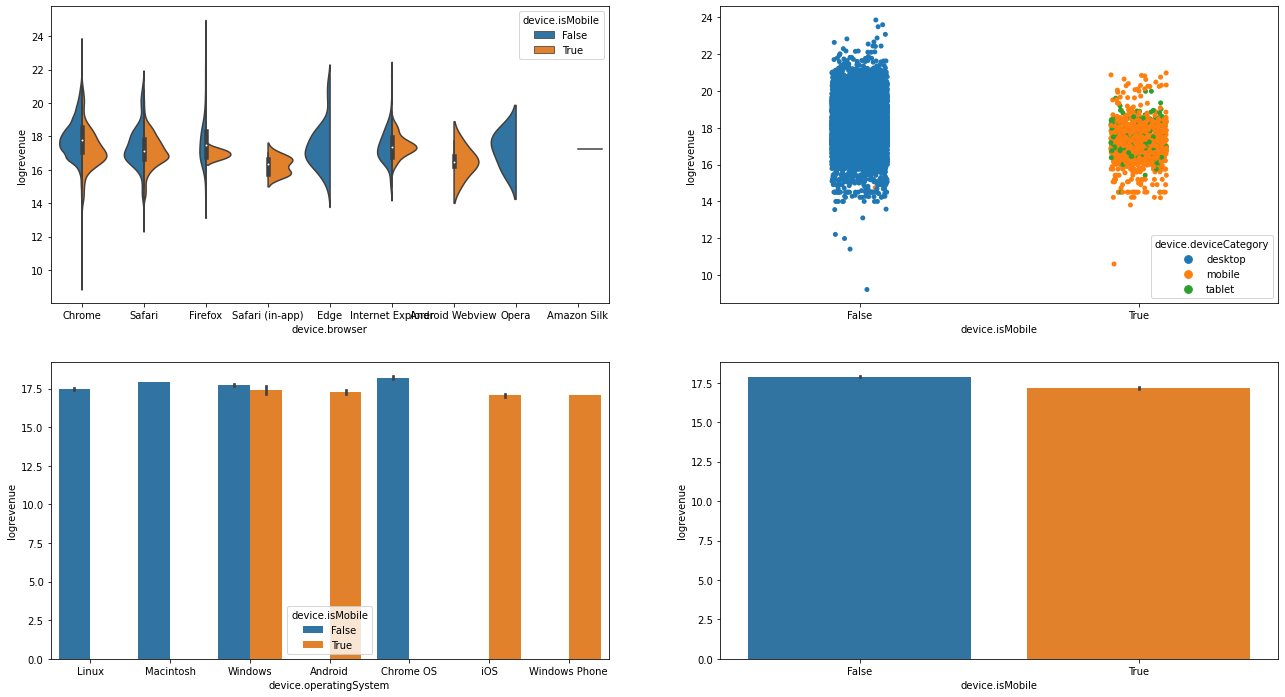

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (22, 12))
df_train = df_train.loc[df_train['logrevenue'] > 0.0]
print('Mean revenue per transaction')
sns.violinplot(x="device.browser", y="logrevenue", hue="device.isMobile", data=df_train, split = True, ax = ax[0, 0]);
sns.stripplot(x="device.isMobile", y="logrevenue", hue="device.deviceCategory", data=df_train, ax = ax[0, 1]);
sns.barplot(x="device.operatingSystem", y="logrevenue", hue="device.isMobile", data=df_train, ax = ax[1, 0]);
sns.barplot(x="device.isMobile", y="logrevenue", data=df_train, ax = ax[1, 1])
plt.show()

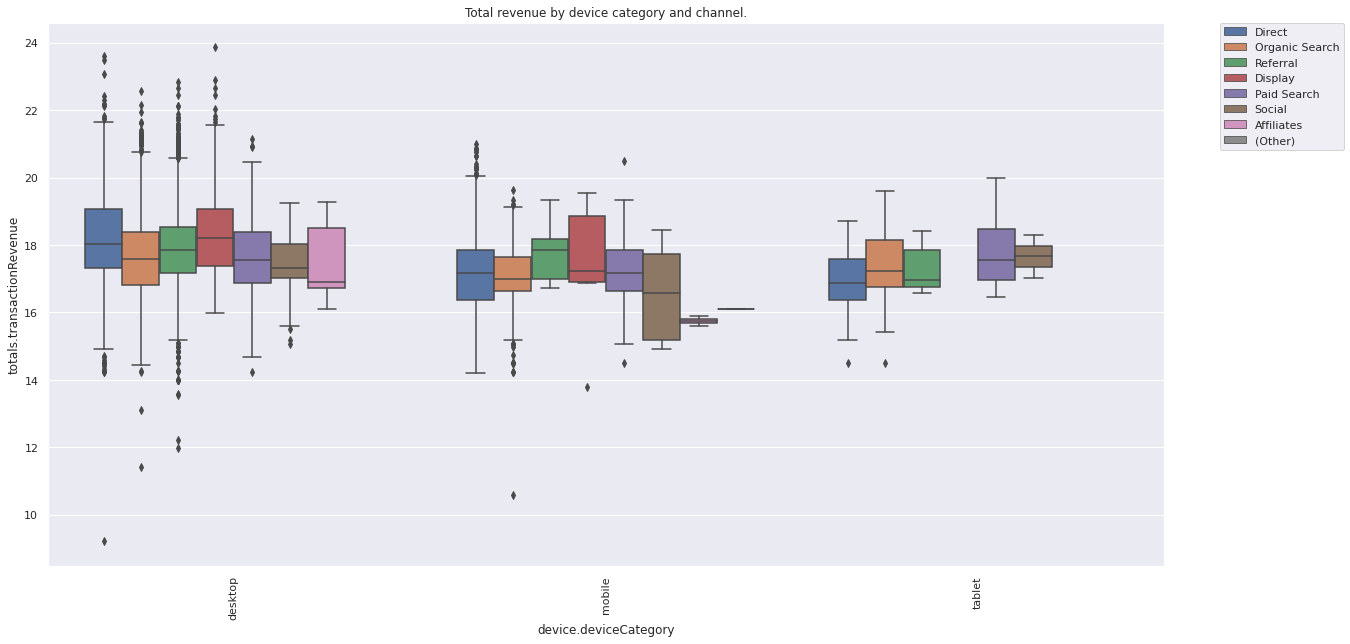

In [ ]:
figsize = (10, 10)
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
target = train['totals.transactionRevenue']
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 10)})
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

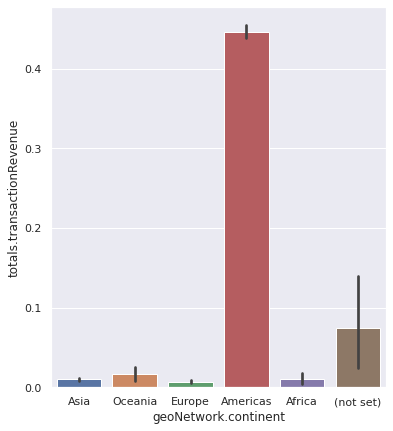

In [ ]:
fig, ax = plt.subplots(0,0,figsize=(6, 7))
sns.barplot(x="geoNetwork.continent", y="totals.transactionRevenue", data=train)

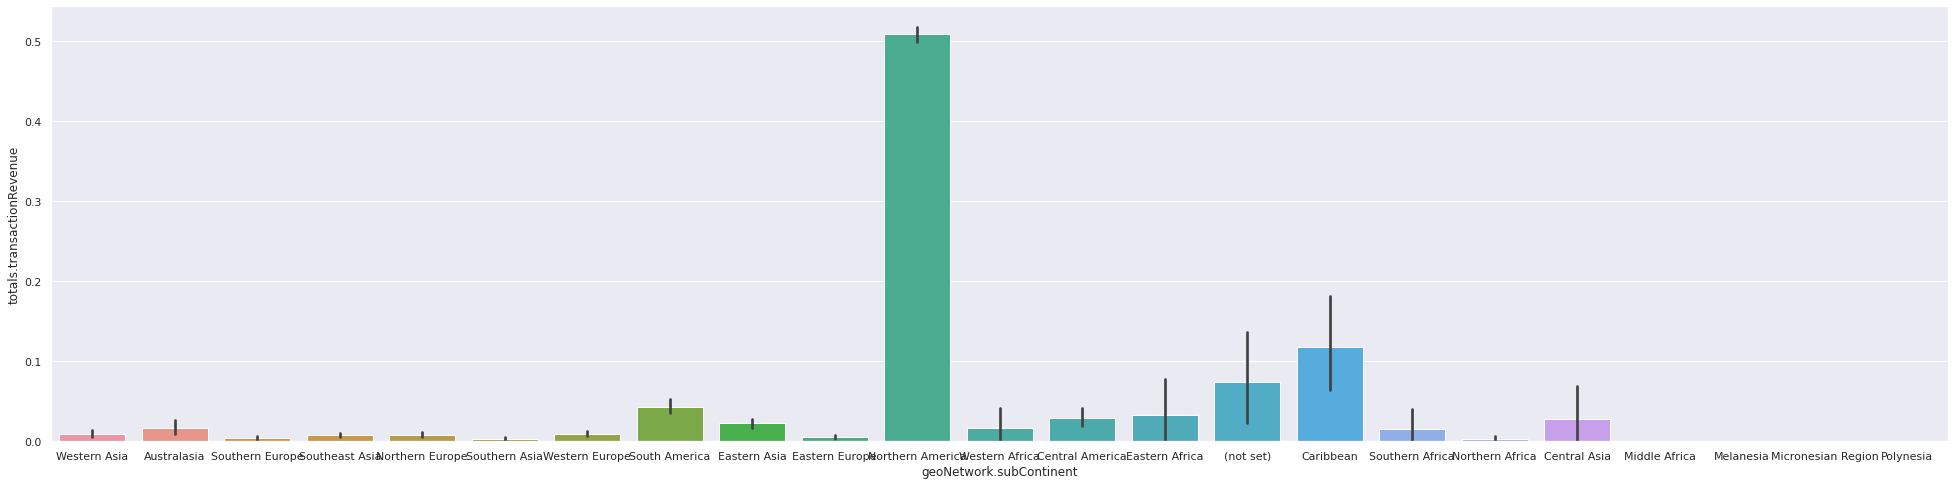

In [ ]:
fig, ax = plt.subplots(0,0,figsize=(34, 8))
sns.barplot(x='geoNetwork.subContinent',y="totals.transactionRevenue", data=train)

In [ ]:
fig, ax = plt.subplots(0,0,figsize=(20,20))
network_country = df_train["geoNetwork.country"].value_counts()
colorscale = [[0, '#14f962'], [0.005, '#15ed11'], 
              [0.01, '#5fe10f'], [0.02, '#a2d50d'], 
              [0.04, '#c9b50b'], [0.05, '#bd6909'], 
              [0.10, '#b12407'], [0.25, '#a50624'], [1.0, '#990557']]

data = [
    dict(
    type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = network_country.index,
        z = network_country.values,
        locationmode = "country names",
        text = network_country.values,
        marker = dict(
            line = dict(color = '#fff' , width = 2)
        )
        
    )
]

layout = dict(
    height = 700,
    title = "Geo Network countries",
    geo =dict(
        showframe = True,
        showocean = True,
        oceancolor = '#0077be',
        projection = dict(
            type = 'orthographic',
            rotation = dict(
                lon = 60,
                lat = 10
            )
        ),
        lonaxis = dict(
            showgrid = False,
            gridcolor = 'rgb(102, 102, 102)'
        ),
        
        lataxis = dict(
            showgrid = False,
            gridcolor = 'rgb(102,102,102)'
        )
    )
)

fig = dict(data= data, layout = layout)
iplot(fig)

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#Feature Engineering 

#remove columns with only one distinct value 
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False)== 1]
train.drop(cols_to_drop, axis=1, inplace=True)

#only one not null value
train.drop(['trafficSource.campaignCode'], axis = 1, inplace = True)

#replace NaN to 0 
train['trafficSource.adContent'] = train['trafficSource.adContent'].fillna(0)
train['trafficSource.keyword'] = train['trafficSource.keyword'].fillna(0)
train['trafficSource.adwordsClickInfo.adNetworkType'] = train['trafficSource.adwordsClickInfo.adNetworkType'].fillna(0)
train['trafficSource.adwordsClickInfo.gclId'] = train['trafficSource.adwordsClickInfo.gclId'].fillna(0)
train['trafficSource.adwordsClickInfo.page'] = train['trafficSource.adwordsClickInfo.page'].fillna(0)
train['trafficSource.adwordsClickInfo.slot'] = train['trafficSource.adwordsClickInfo.slot'].fillna(0)

#adding new features
train['browser_category'] = train['device.browser'] + '_' + train['device.deviceCategory']
train['browser_operatingSystem'] = train['device.browser'] + '_' + train['device.operatingSystem']
train['source_country'] = train['trafficSource.source'] + '_' + train['geoNetwork.country']

In [ ]:
train_graph = train_ 

In [ ]:
train_graph['totals.transactionRevenue'] = pd.to_numeric(train_graph['totals.transactionRevenue'], downcast="float")
train_graph['totals.hits'] = pd.to_numeric(train_graph['totals.hits'], downcast="float")
train_graph["totals.pageviews"] = pd.to_numeric(train_graph['totals.pageviews'], downcast="float")

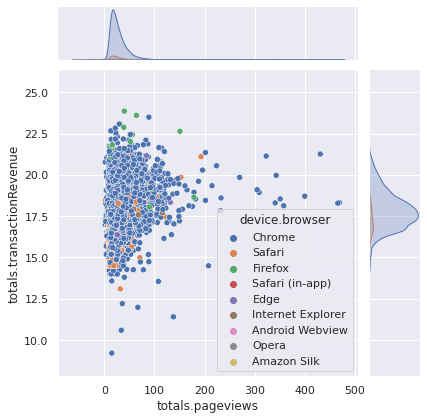

In [ ]:
sns.jointplot(data=train_graph, x="totals.pageviews", y="totals.transactionRevenue", hue ="device.browser")           

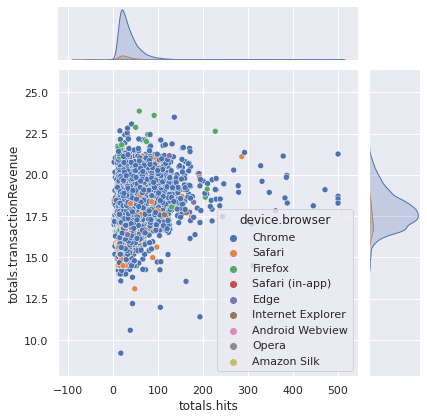

In [ ]:
sns.jointplot(data=train_graph, x="totals.hits", y="totals.transactionRevenue", hue ="device.browser") 

<Figure size 1296x1296 with 0 Axes>

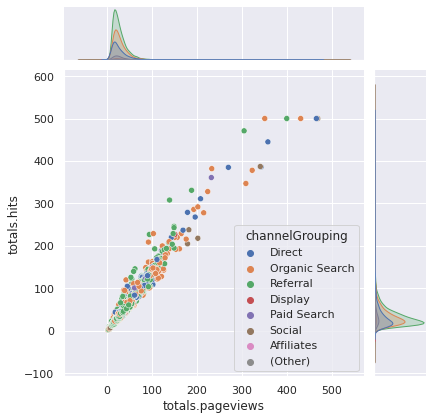

In [ ]:
fig = plt.figure(figsize=(18,18))
sns.jointplot(data=train_graph, x="totals.pageviews", y="totals.hits", hue ="channelGrouping")           

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



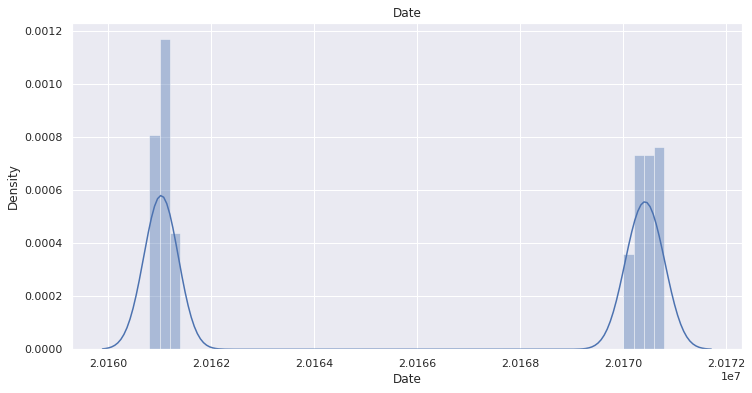

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(train['date'])
plt.xlabel('Date')
plt.title('Date')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



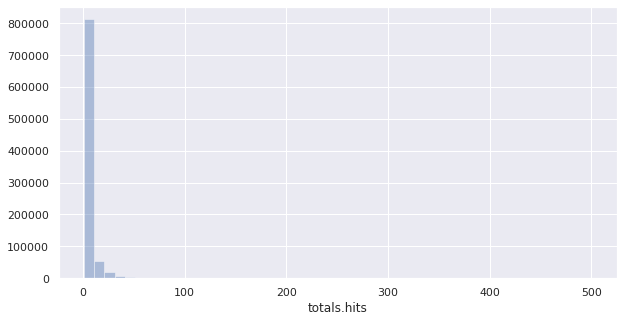

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.distplot(train["totals.hits"],kde=False)

In [ ]:
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue']
# deal with num_cols
for col in num_cols:
    train[col] = train[col].fillna(0)
    train[col] = train[col].astype(float)
    train[col] = np.log1p(train[col])

In [ ]:
#remove useless columns
no_use = ["date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']
cat_cols = [col for col in train.columns if col not in num_cols and col not in no_use]

#categorical encoding 
max_values = {}
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    max_values[col] = train[col].max() + 2  # slightly larger than the real is better 

channelGrouping
device.browser
device.operatingSystem
device.isMobile
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.isTrueDirect
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adContent
logrevenue
browser_category
browser_operatingSystem
source_country


In [ ]:
#remove column with only one distinct value in test
cols_to_drop = [col for col in test.columns if test[col].nunique(dropna=False)== 1]
test.drop(cols_to_drop, axis=1, inplace=True)

test.head(3)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220


In [ ]:
def load_df(csv_path='/content/drive/MyDrive/drive/test.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,converters={column: json.loads for column in JSON_COLUMNS},dtype={'fullVisitorId': 'str'},nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
test = load_df()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded test.csv. Shape: (804684, 53)


In [ ]:
#replace NaN to 0 
test['trafficSource.adContent'] = test['trafficSource.adContent'].fillna(0)
test['trafficSource.keyword'] = test['trafficSource.keyword'].fillna(0)
test['trafficSource.adwordsClickInfo.adNetworkType'] = test['trafficSource.adwordsClickInfo.adNetworkType'].fillna(0)
test['trafficSource.adwordsClickInfo.gclId'] = test['trafficSource.adwordsClickInfo.gclId'].fillna(0)
test['trafficSource.adwordsClickInfo.page'] = test['trafficSource.adwordsClickInfo.page'].fillna(0)
test['trafficSource.adwordsClickInfo.slot'] = test['trafficSource.adwordsClickInfo.slot'].fillna(0)

from numpy import testing
#adding new features
test['browser_category'] = test['device.browser'] + '_' + test['device.deviceCategory']
test['browser_operatingSystem'] = test['device.browser'] + '_' + test['device.operatingSystem']
test['source_country'] = test['trafficSource.source'] + '_' + test['geoNetwork.country']

In [ ]:
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits']
# deal wit num_cols
for col in num_cols:
    test[col] = test[col].fillna(0)
    test[col] = test[col].astype(float)
    test[col] = np.log1p(test[col])

In [ ]:
#remove useless columns
no_use = ["date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'trafficSource.referralPath']
cat_cols = [col for col in test.columns if col not in num_cols and col not in no_use]

max_values = {}
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(test[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    max_values[col] = test[col].max() + 2  # slightly larger than real value is better so +2

channelGrouping
socialEngagementType
device.browser
device.browserVersion
device.browserSize
device.operatingSystem
device.operatingSystemVersion
device.isMobile
device.mobileDeviceBranding
device.mobileDeviceModel
device.mobileInputSelector
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.flashVersion
device.language
device.screenColors
device.screenResolution
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.cityId
geoNetwork.networkDomain
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
totals.visits
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.isTrueDirect
trafficSource.adwordsClickInfo.criteriaParameters
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.isVideoAd


In [ ]:
cat_cols

['channelGrouping',
 'socialEngagementType',
 'device.browser',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.isMobile',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.networkDomain',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.page',
 'trafficSo

In [ ]:
import datetime
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [ ]:
train.info() #errer because revenue in train !! need to delete it 
test.info()

In [ ]:
import datetime
train = train.sort_values('date')

In [ ]:
dev_df = train[train["date"] <= pd.Timestamp(2017,5,31)]
val_df = train[train["date"] > pd.Timestamp(2017,5,31)]

In [ ]:
dev_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765707 entries, 538448 to 897204
Data columns (total 39 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               765707 non-null  int64  
 1   date                                          765707 non-null  object 
 2   fullVisitorId                                 765707 non-null  object 
 3   sessionId                                     765707 non-null  object 
 4   visitId                                       765707 non-null  int64  
 5   visitNumber                                   765707 non-null  float64
 6   visitStartTime                                765707 non-null  int64  
 7   device.browser                                765707 non-null  int64  
 8   device.operatingSystem                        765707 non-null  int64  
 9   device.isMobile                            

In [ ]:
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

In [ ]:
dev_X = dev_df.drop("totals.transactionRevenue", axis =1 )
val_X = val_df.drop("totals.transactionRevenue", axis =1 )

In [ ]:
dev_X = dev_X.drop(no_use, axis = 1)

In [ ]:
val_X = val_X.drop(no_use, axis = 1)

In [ ]:
test_X = test.drop(no_use, axis = 1)

In [ ]:
dev_X.info()
val_X.info()

In [ ]:
test_X.info()

In [ ]:
import lightgbm as lgb

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 50,
        "min_child_samples" : 200,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2022,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.00333959
[200]	valid_0's rmse: 0.00237544
[300]	valid_0's rmse: 0.00210425
[400]	valid_0's rmse: 0.00197234
[500]	valid_0's rmse: 0.00189124
[600]	valid_0's rmse: 0.00183386
[700]	valid_0's rmse: 0.00179001
[800]	valid_0's rmse: 0.00176146
[900]	valid_0's rmse: 0.00173243
[1000]	valid_0's rmse: 0.00171068
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.00171068


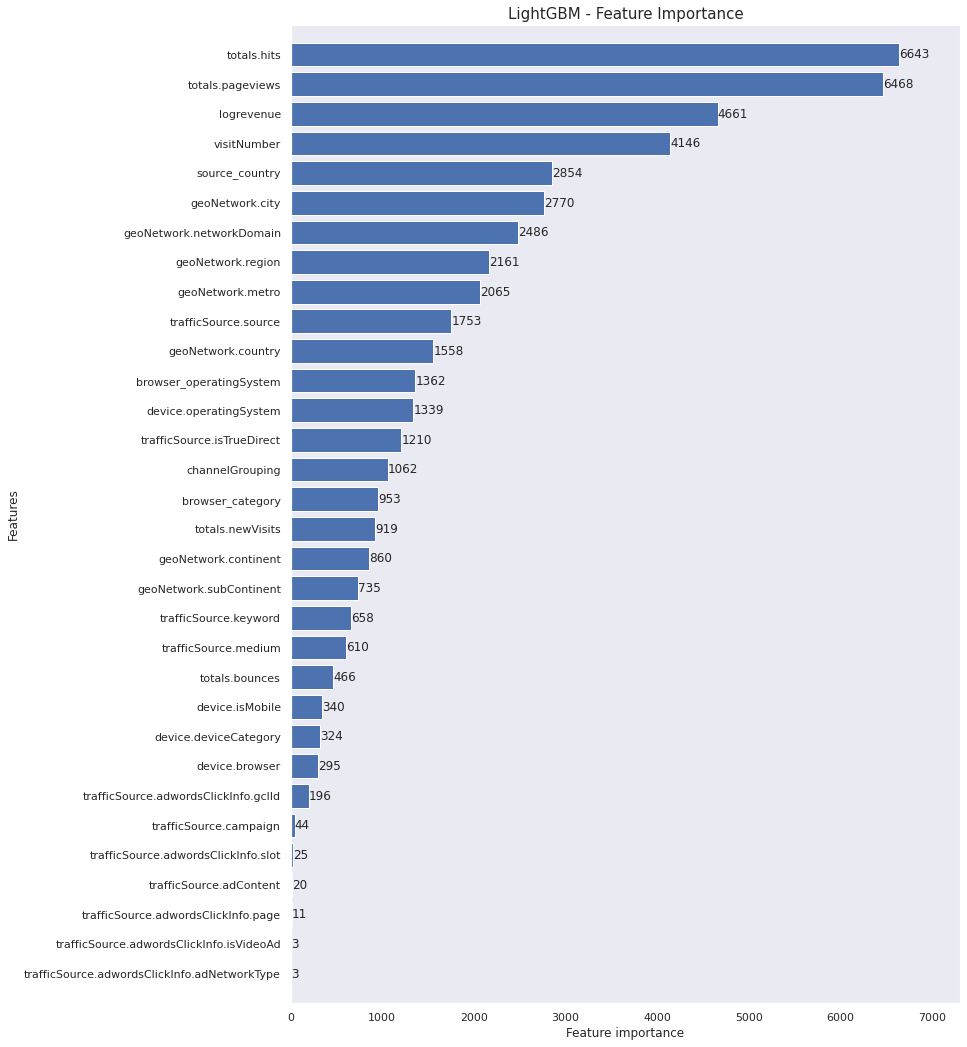

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()